In [1]:
## 보스턴 주택 데이터세트 로드

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
## 데이터세트 포멧 확인

print(train_data[0])  # 주택 수치 특성, 총 13개의 특성(범죄율, 주택당 평균 방수 등)
print(train_targets[0])  # 주택 중간 가격, 1000달러 단위(1~5만달러 사이)

print(train_data.shape)  # 훈련데이터 404개+13속성, 훈련타겟 404개+1속성
print(train_targets.shape)
print(test_data.shape)  # 테스트데이터 102개+13속성, 테스트타겟 102개+1속성
print(test_targets.shape)

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2
(404, 13)
(404,)
(102, 13)
(102,)


In [3]:
## 데이터 표준화

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean  # 훈련데이터로 산출한 mean, std 로만 테스트데이터에 적용해야함!
test_data /= std

In [4]:
## 모델 정의

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [5]:
## K-fold 교차검증

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 : #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [ train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:] ], axis=0)
    
    partial_train_targets = np.concatenate(
        [ train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:] ], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=False)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=False)
    all_scores.append(val_mae)

print(all_scores)  # 각 폴드별 검증세트 평가점수 목록
print(np.mean(all_scores))  # 전체 폴드 검증세트 평가점수 평균

처리중인 폴드 : # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
처리중인 폴드 : # 1
처리중인 폴드 : # 2
처리중인 폴드 : # 3
[2.0709603564573986, 2.246034815759942, 3.0001856643374603, 2.32592104862232]
2.41077547129428


In [6]:
## 각 폴드별 검증점수 로그 저장

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 : #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [ train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:] ], axis=0)
    
    partial_train_targets = np.concatenate(
        [ train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:] ], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=False)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
# print(all_mae_histories)

처리중인 폴드 : # 0
처리중인 폴드 : # 1
처리중인 폴드 : # 2
처리중인 폴드 : # 3


In [7]:
## K-fold 검증점수 평균 계산

average_mae_history = [
    np.mean([ x[i] for x in all_mae_histories ]) for i in range(num_epochs)
]
# print(all_mae_histories)

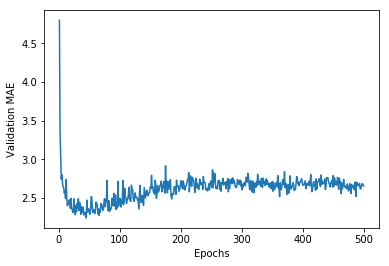

In [8]:
## 검증점수 그래프

%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

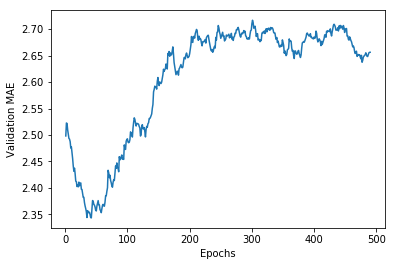

In [9]:
## 처음 10개 데이터포인트 제외 검증점수 그래프

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.clf()
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [10]:
## 최종 모델 훈련

model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=False)
test_mes_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 1ms/step
2.677062287050135
